In [53]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import datetime as dt
import sklearn.metrics
import seaborn as sns
import statsmodels.formula.api as smf

import warnings; warnings.simplefilter('ignore')

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.feature_selection import RFE
from datetime import datetime
from pandas import Series, DataFrame
from pandas.plotting import scatter_matrix
from sklearn.metrics import classification_report
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, precision_recall_curve, roc_curve, auc, log_loss
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
plt.rc("font", size=14)
sns.set(style="white") #white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)

## Load and describe the data

## Dataset

The raw dataset includes all weekly performance information for all LOCs(18,833 unique loan ids) that has originated between 2013-09-18 and 2018-05-02: 1,236,623 observations in total.

## Data Dictionary

### Target Variable
1. write_off_flag -  Loan default status.  The status is a binary variable, where 1 means "Yes" and 0 means "No".

### Input Variables
1. loan_id - The unique identifier for each LOC account.    
2. as_of_date - The effective date that reflects what each metric on that table was as of the specific date in    
   question.
3. total_outstanding_principal - The Outstanding Prinicipal owed on the LOC account.
4. last_draw_date - The date of the most recent draw made that is still in a cleared state.
5. dpd_calendar - The count of days past due in "calendar days".
6. last_cleared_payment_date - The date of the most recent regular and one-time payment made that is still in a 
   cleared state.
7. credit_limit - The credit limit of the LOC account on the as_of_date.
8. lsp_wo_new_principal - The sum of the amounts of principal of both write off and additional write off transactions.
9. lsp_wo_new_interest - The sum of the amounts of interest of both write off and additional write off transactions.
10. past_due_principal - The Prinicipal that is past due on the LOC account (this is a subset of the Outstanding    
    Principal).
11. past_due_interest - The Interest that is past due on the LOC account (this is a subset of the Outstanding 
    Interest).
12. write_off_date - The date the LOC account was written off.
13. current_utilization_pct - The percentage that is being used by the merchant as of the specific day in question 
    (i.e. prinicipal owed over credit limit).
14. lifetime_i_paid - The total amount of regular and ot interest the merchant has paid since LSP has boarded the 
    loan.
15. lifetime_p_paid - The total amount of regular and ot principal the merchant has paid since LSP has boarded the 
    loan.
16. lifetime_missed_payments - The count of missed and error regular payments since LSP has boarded the loan.
17. lifetime_partial_payments - The count of "partial regular payments" made by the merchant since LSP has boarded the 
    loan.
18. lifetime_ot_payments - The count of "one-time" payments made since LSP has boarded the loan.
19. first_draw_date - The date of the first draw made by the merchant since LSP has boarded the loan.
20. age_months - The age in months since LSP boarded this account.
21. lifetime_utilization_pct - The percentage that is being used by the merchant using the daily average balance as 
    the numerator.
22. lifetime_draw_count - The count of draws requested by the merchant since LSP has boarded the loan.
23. closedate - The date the LOC was boarded into LSP, whether they drew on that day or not.
24. wa_credit_score__c - merchant credit score.


In [54]:
line_of_credit = pd.read_csv('/Users/rcalaquian/ga-projects/data/loc_sample1.csv', parse_dates=['as_of_date', 'firstdate', 'first_draw_date', 'last_cleared_payment_date'],date_parser=lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [55]:
line_of_credit.head()

,loan_id,as_of_date,total_outstanding_principal,last_draw_date,dpd_calendar,last_cleared_payment_date,credit_limit,lsp_wo_new_principal,lsp_wo_new_interest,past_due_principal,...,age_months,lifetime_utilization_pct,lifetime_draw_count,closedate,wa_credit_score__c,dpd10slope,firstdate,lastdlqdate,firstdlq,write_off_flag
0,A0005379235221,2015-09-30,5813.81,2015-05-11,64.0,2015-09-30,10000.0,NaN,NaN,3636.07,...,6,0.775821,4,2015-03-27,625.0,1.145455,2015-03-27,2015-07-28,2015-05-13,0
1,A0005379235221,2015-10-07,5467.31,2015-05-11,71.0,2015-10-07,10000.0,NaN,NaN,3635.78,...,7,0.768664,4,2015-03-27,625.0,0.636364,2015-03-27,2015-07-28,2015-05-13,0
2,A0005379235221,2015-10-28,4413.35,2015-05-11,71.0,2015-10-28,10000.0,NaN,NaN,3634.91,...,7,0.743199,4,2015-03-27,625.0,0.127273,2015-03-27,2015-07-28,2015-05-13,0
3,A0005379235221,2015-11-04,4057.15,2015-05-11,71.0,2015-11-04,10000.0,NaN,NaN,3634.62,...,8,0.733564,4,2015-03-27,625.0,0.509091,2015-03-27,2015-07-28,2015-05-13,0
4,A0005379235221,2015-11-11,4057.15,2015-05-11,78.0,2015-11-04,10000.0,NaN,NaN,3634.62,...,8,0.723586,4,2015-03-27,625.0,1.209091,2015-03-27,2015-07-28,2015-05-13,0


In [56]:
line_of_credit.describe()

,total_outstanding_principal,dpd_calendar,credit_limit,lsp_wo_new_principal,lsp_wo_new_interest,past_due_principal,past_due_interest,current_utilization_pct,lifetime_i_paid,lifetime_p_paid,lifetime_missed_payments,lifetime_partial_payments,lifetime_ot_payments,age_months,lifetime_utilization_pct,lifetime_draw_count,wa_credit_score__c,dpd10slope,write_off_flag
count,1.103489e+06,1.003810e+06,1.103489e+06,104131.000000,104131.000000,1.103489e+06,1.103489e+06,1.103489e+06,1.100756e+06,1.103489e+06,1.103489e+06,1.103489e+06,1.103489e+06,1.103489e+06,1.103489e+06,1.103489e+06,1.100990e+06,1.098492e+06,1.103489e+06
mean,7.873473e+03,3.797971e+00,1.928879e+04,12212.162007,1294.452012,2.209803e+02,2.579477e+01,4.115748e-01,3.155819e+03,2.842991e+04,3.490378e+00,2.215841e+00,1.920723e+00,1.420939e+01,4.427196e-01,9.691105e+00,6.810809e+02,3.286192e-02,9.436524e-02
std,9.473122e+03,2.081864e+01,1.210724e+04,6569.400845,942.609765,1.348651e+03,1.820852e+02,3.639264e-01,3.499048e+03,3.559053e+04,7.662478e+00,6.825719e+00,6.265269e+00,9.476268e+00,2.585671e-01,1.104178e+01,5.271456e+01,1.587804e+00,2.923363e-01
min,-1.642722e+04,0.000000e+00,6.000000e+03,0.010000,0.000000,0.000000e+00,0.000000e+00,-1.156365e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-9.891690e-03,1.000000e+00,4.430000e+02,-4.790909e+01,0.000000e+00
25%,0.000000e+00,0.000000e+00,1.300000e+04,8236.790000,609.900000,0.000000e+00,0.000000e+00,0.000000e+00,6.839775e+02,6.622990e+03,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00,2.246827e-01,2.000000e+00,6.430000e+02,0.000000e+00,0.000000e+00
50%,5.299240e+03,0.000000e+00,1.700000e+04,11884.310000,1117.340000,0.000000e+00,0.000000e+00,3.929526e-01,1.922910e+03,1.805962e+04,0.000000e+00,0.000000e+00,1.000000e+00,1.300000e+01,4.387325e-01,6.000000e+00,6.760000e+02,0.000000e+00,0.000000e+00
75%,1.260014e+04,0.000000e+00,2.000000e+04,14948.960000,1767.200000,0.000000e+00,0.000000e+00,7.815777e-01,4.433100e+03,3.873118e+04,2.000000e+00,1.000000e+00,2.000000e+00,2.100000e+01,6.587690e-01,1.300000e+01,7.140000e+02,0.000000e+00,0.000000e+00
max,1.000000e+05,6.590000e+02,1.000000e+05,99729.970000,8410.920000,6.282918e+04,7.968240e+03,2.272423e+00,3.671027e+04,1.258478e+06,6.400000e+01,8.300000e+01,3.240000e+02,4.500000e+01,1.309138e+00,1.430000e+02,8.500000e+02,5.709091e+01,1.000000e+00


In [57]:
print('The total number of samples is {}.'.format(line_of_credit.shape[0]))

The total number of samples is 1103489.


In [58]:
line_of_credit.dtypes

loan_id                                object
as_of_date                     datetime64[ns]
total_outstanding_principal           float64
last_draw_date                         object
dpd_calendar                          float64
last_cleared_payment_date      datetime64[ns]
credit_limit                          float64
lsp_wo_new_principal                  float64
lsp_wo_new_interest                   float64
past_due_principal                    float64
past_due_interest                     float64
write_off_date                         object
current_utilization_pct               float64
lifetime_i_paid                       float64
lifetime_p_paid                       float64
lifetime_missed_payments                int64
lifetime_partial_payments               int64
lifetime_ot_payments                    int64
first_draw_date                datetime64[ns]
age_months                              int64
lifetime_utilization_pct              float64
lifetime_draw_count               

In [59]:
len(line_of_credit['loan_id'].unique())

16997

There are 16,997 unique loans.

In [60]:
line_of_credit['age_months'].value_counts().head()

7    46950
8    46828
6    46624
5    46367
9    46338
Name: age_months, dtype: int64

In [61]:
# slicing the data by age_months using 7 months as this has the most sample?  observations?.
line_of_credit = line_of_credit.loc[line_of_credit['age_months'] == 7]

In [62]:
line_of_credit.isnull().sum()

loan_id                            0
as_of_date                         0
total_outstanding_principal        0
last_draw_date                     0
dpd_calendar                    1312
last_cleared_payment_date          0
credit_limit                       0
lsp_wo_new_principal           45583
lsp_wo_new_interest            45583
past_due_principal                 0
past_due_interest                  0
write_off_date                 45583
current_utilization_pct            0
lifetime_i_paid                   19
lifetime_p_paid                    0
lifetime_missed_payments           0
lifetime_partial_payments          0
lifetime_ot_payments               0
first_draw_date                    0
age_months                         0
lifetime_utilization_pct           0
lifetime_draw_count                0
closedate                          0
wa_credit_score__c                66
dpd10slope                         1
firstdate                          0
lastdlqdate                    32812
f

In [63]:
# percent of missing "write_off_date" 
print('Percent of missing "write_off_date" records is %.2f%%' %((line_of_credit['write_off_date'].isnull().sum()/line_of_credit.shape[0])*100))

Percent of missing "write_off_date" records is 97.09%


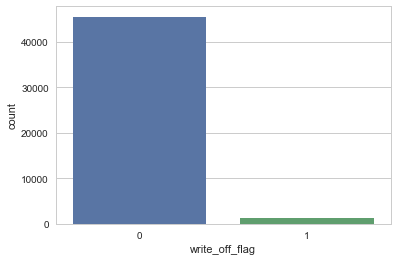

In [64]:
sns.countplot(x='write_off_flag', data=line_of_credit)
plt.show()
plt.savefig('count_plot')

In [65]:
print('Percent of missing "wa_credit_score__c" records is %.2f%%' %((line_of_credit['wa_credit_score__c'].isnull().sum()/line_of_credit.shape[0])*100))

Percent of missing "wa_credit_score__c" records is 0.14%


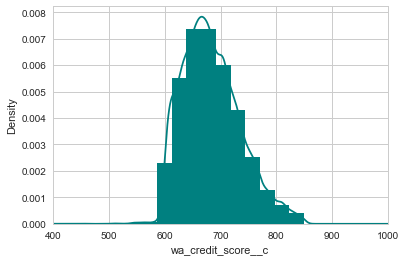

In [66]:
ax = line_of_credit["wa_credit_score__c"].hist(bins=15, density=True, stacked=True, color='teal')#, alpha=0.6)
line_of_credit["wa_credit_score__c"].plot(kind='density', color='teal')
ax.set(xlabel='wa_credit_score__c')
plt.xlim(400,1000)
plt.show()

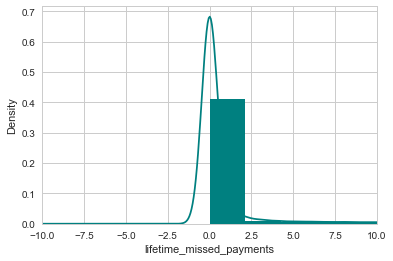

In [67]:
ax = line_of_credit["lifetime_missed_payments"].hist(bins=15, density=True, stacked=True, color='teal')#, alpha=0.6)
line_of_credit["lifetime_missed_payments"].plot(kind='density', color='teal')
ax.set(xlabel='lifetime_missed_payments')
plt.xlim(-10,10)
plt.show()

In [68]:
target = ['write_off_flag']
inputs = [column for column in line_of_credit.columns.values.tolist() if (column not in target)] 

In [69]:
y = line_of_credit[target]
X = line_of_credit[inputs]

In [70]:
line_of_credit['as_of_date'].min()

Timestamp('2015-09-30 00:00:00')

In [71]:
line_of_credit['as_of_date'].max()

Timestamp('2017-06-28 00:00:00')

The raw dataset includes weekly performance information on Wednesday for Company xx's line of credit originated between 2015-09-30 and 2017-06-28.  

in total, 45,583 did not default and the remaining 1,367 defaulted.

In [72]:
line_of_credit.groupby('write_off_flag').mean()

,total_outstanding_principal,dpd_calendar,credit_limit,lsp_wo_new_principal,lsp_wo_new_interest,past_due_principal,past_due_interest,current_utilization_pct,lifetime_i_paid,lifetime_p_paid,lifetime_missed_payments,lifetime_partial_payments,lifetime_ot_payments,age_months,lifetime_utilization_pct,lifetime_draw_count,wa_credit_score__c,dpd10slope
write_off_flag,,,,,,,,,,,,,,,,,,
0,8919.12465,4.061251,19694.535243,NaN,NaN,251.264328,27.021393,0.476278,1662.250493,17204.599094,0.976351,0.726718,1.167168,7.0,0.473410,5.321128,684.408089,0.231632
1,394.70605,89.290909,13539.136796,10985.742977,1034.815655,231.785977,36.023819,0.032480,583.587659,3277.171090,15.657644,0.252377,0.376737,7.0,0.607717,2.966350,663.722019,-5.156755


#### In order to gain an understanding of the two groups, the mean of each of the independent variables were calculated.
#### Observations:
The average total_outstanding_principal for loans that defaulted is lower than total_outstanding_principal for loans 
that did not default.
The average credit_limit for loans that defaulted is lower than those that did not default.
The average current_utilization_pct is 20x lower for loan that defaulted compared to loans that did not default.
The average age of loan is is 7months older for those who defailted than those who did not.

## Clean & Explore the Data

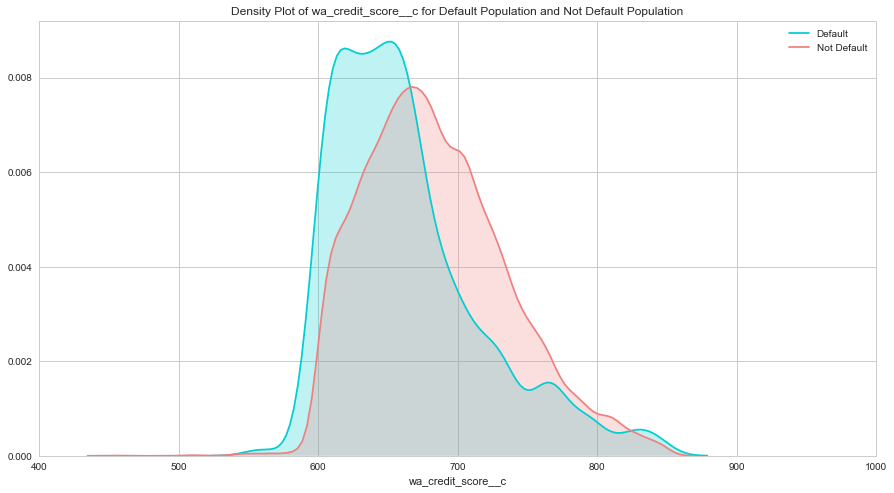

In [98]:
plt.figure(figsize=(15,8))
ax = sns.kdeplot(line_of_credit["wa_credit_score__c"][line_of_credit.write_off_flag  == 1], color="darkturquoise", shade=True)
sns.kdeplot(line_of_credit["wa_credit_score__c"][line_of_credit.write_off_flag == 0], color="lightcoral", shade=True)
plt.legend(['Default', 'Not Default'])
plt.title('Density Plot of wa_credit_score__c for Default Population and Not Default Population')
ax.set(xlabel='wa_credit_score__c')
plt.xlim(400,1000)
plt.show()

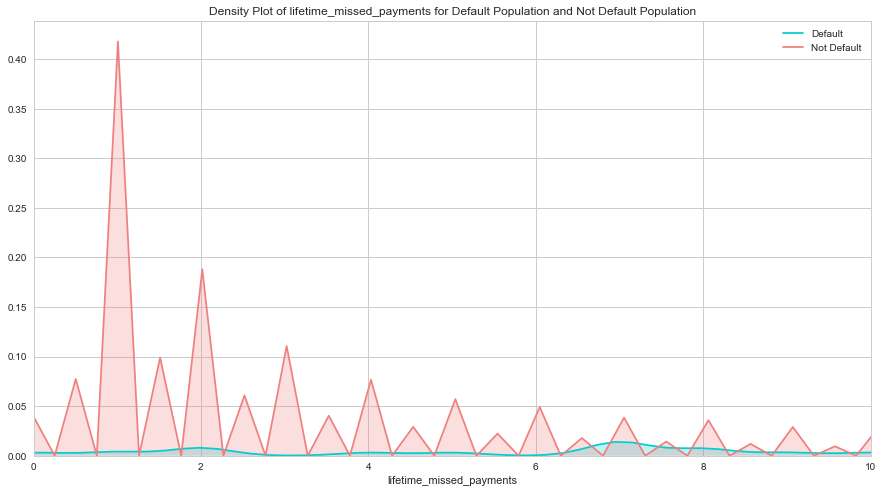

In [104]:
plt.figure(figsize=(15,8))
ax = sns.kdeplot(line_of_credit["lifetime_missed_payments"][line_of_credit.write_off_flag  == 1], color="darkturquoise", shade=True)
sns.kdeplot(line_of_credit["lifetime_missed_payments"][line_of_credit.write_off_flag == 0], color="lightcoral", shade=True)
plt.legend(['Default', 'Not Default'])
plt.title('Density Plot of lifetime_missed_payments for Default Population and Not Default Population')
ax.set(xlabel='lifetime_missed_payments')
plt.xlim(0,10)
plt.show()

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [76]:
# Data cleanup and feature angineering
def feature_engineering(data_frame):
    bit = [0, 1]
    
    data_frame['missed_sub_partial'] = data_frame['lifetime_missed_payments'] - data_frame['lifetime_partial_payments']
    data_frame['current_utilization_pct'].fillna(0, inplace=True)

    data_frame['lifetime_missed_payments_norm_age'] = data_frame['lifetime_missed_payments'] / (data_frame['age_months'] + 1)

    data_frame['first_draw_since_close'] = np.maximum((data_frame['first_draw_date'] - data_frame['firstdate'])/np.timedelta64(1, 'D'), 0)   
    data_frame['first_draw_since_close_factor'] = np.where(data_frame['first_draw_since_close'].isin(bit), 1, 0)
    
    data_frame['ipratio'] = np.minimum(np.where(data_frame['lifetime_p_paid'] <= 0 | data_frame['lifetime_p_paid'].isnull(), 1,
                                         data_frame['lifetime_i_paid']/data_frame['lifetime_p_paid']), 1)
    data_frame['has_ipratio'] = np.where(data_frame['lifetime_p_paid'] > 0, 1, 0)
    data_frame['wa_credit_score__c'].fillna(678, inplace=True)
    
    data_frame['pastdue_ipratio'] = np.where(data_frame['past_due_principal'] > 0, 
                                   data_frame['past_due_interest']/data_frame['past_due_principal'], 1)
    data_frame['has_pastdue_principal'] = np.where(data_frame['past_due_principal'] > 0, 1, 0)
    
    data_frame['daysSinceLastPay'] = np.floor(((data_frame['as_of_date'] - data_frame['last_cleared_payment_date'])/np.timedelta64(1, 'D'))) 
    data_frame['daysSinceLastPayInt'] = data_frame['daysSinceLastPay']/7
    data_frame['dpd_calendar'].fillna(0, inplace=True)
    
    return(data_frame)

In [77]:
# X_train feature engineering.
X_train = feature_engineering(X_train)
# X_test feature engineering.
X_test = feature_engineering(X_test)

In [78]:
features = ['missed_sub_partial','current_utilization_pct','lifetime_missed_payments_norm_age',
            'has_ipratio','has_pastdue_principal', 'wa_credit_score__c', 'first_draw_since_close_factor', 'daysSinceLastPayInt']  

In [79]:
# Build a logreg and compute the feature importances
logreg = LogisticRegression()
# create the RFE model and select 8 attributes
X = X_train[features]
y = y_train[target]

rfe = RFE(logreg, 8)
rfe = rfe.fit(X, y)
# summarize the selection of the attributes
print('Selected features: %s' % list(X.columns[rfe.support_]))

Selected features: ['missed_sub_partial', 'current_utilization_pct', 'lifetime_missed_payments_norm_age', 'has_ipratio', 'has_pastdue_principal', 'wa_credit_score__c', 'first_draw_since_close_factor', 'daysSinceLastPayInt']


Optimal number of features: 4
Selected features: ['current_utilization_pct', 'lifetime_missed_payments_norm_age', 'has_ipratio', 'has_pastdue_principal']


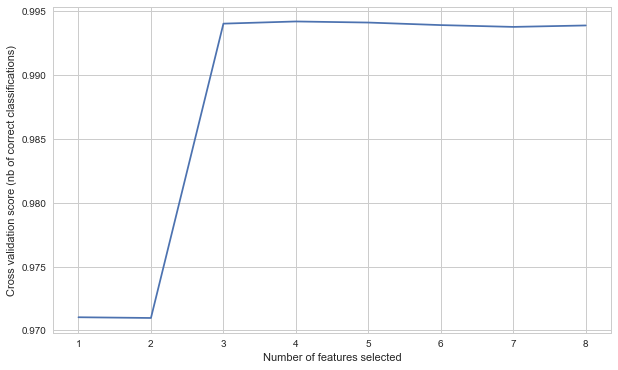

In [80]:
from sklearn.feature_selection import RFECV
# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring is proportional to the number of correct classifications
rfecv = RFECV(estimator=LogisticRegression(), step=1, cv=10, scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(X.columns[rfecv.support_]))

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

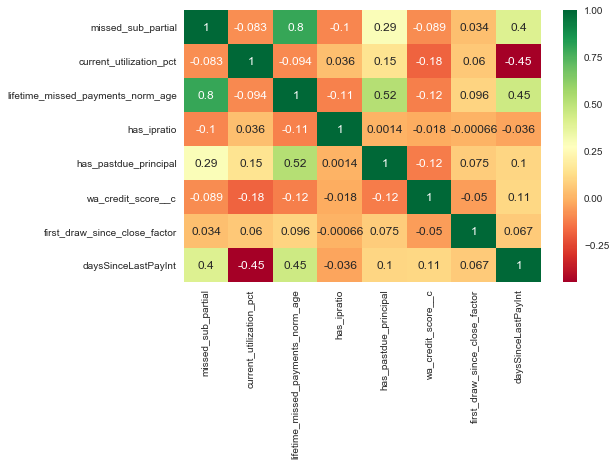

In [81]:
X = X_train[features]

plt.subplots(figsize=(8, 5))
sns.heatmap(X.corr(), annot=True, cmap="RdYlGn")
plt.show()

### Modeling

Train/Test split results:
LogisticRegression accuracy is 0.995
LogisticRegression log_loss is 0.020
LogisticRegression auc is 0.994


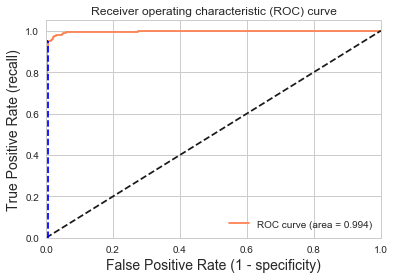

Using a threshold of 0.088 guarantees a sensitivity of 0.952 and a specificity of 0.993, i.e. a false positive rate of 0.66%.


In [82]:
# use train/test split with different random_state values
# we can change the random_state values that changes the accuracy scores
# the scores change a lot, this is why testing scores is a high-variance estimate

# check classification scores of logistic regression
logreg = LogisticRegression()
logreg.fit(X_train[features], y_train)
y_pred = logreg.predict(X_test[features])
y_pred_proba = logreg.predict_proba(X_test[features])[:, 1]
[fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)
print('Train/Test split results:')
print(logreg.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test, y_pred))
print(logreg.__class__.__name__+" log_loss is %2.3f" % log_loss(y_test, y_pred_proba))
print(logreg.__class__.__name__+" auc is %2.3f" % auc(fpr, tpr))

idx = np.min(np.where(tpr > 0.95)) # index of the first threshold for which the sensibility > 0.95

plt.figure()
plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

print("Using a threshold of %.3f " % thr[idx] + "guarantees a sensitivity of %.3f " % tpr[idx] +  
      "and a specificity of %.3f" % (1-fpr[idx]) + 
      ", i.e. a false positive rate of %.2f%%." % (np.array(fpr[idx])*100))

In [83]:
# 10-fold cross-validation logistic regression
logreg = LogisticRegression()
# Use cross_val_score function
# We are passing the entirety of X and y, not X_train or y_train, it takes care of splitting the data
# cv=10 for 10 folds
# scoring = {'accuracy', 'neg_log_loss', 'roc_auc'} for evaluation metric - althought they are many
scores_accuracy = cross_val_score(logreg, X_train[features], y_train, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(logreg, X_train[features], y_train, cv=10, scoring='neg_log_loss')
scores_auc = cross_val_score(logreg, X_train[features], y, cv=10, scoring='roc_auc')
print('K-fold cross-validation results:')
print(logreg.__class__.__name__+" average accuracy is %2.3f" % scores_accuracy.mean())
print(logreg.__class__.__name__+" average log_loss is %2.3f" % -scores_log_loss.mean())
print(logreg.__class__.__name__+" average auc is %2.3f" % scores_auc.mean())

K-fold cross-validation results:
LogisticRegression average accuracy is 0.994
LogisticRegression average log_loss is 0.023
LogisticRegression average auc is 0.992


In [84]:
scoring = {'accuracy': 'accuracy', 'log_loss': 'neg_log_loss', 'auc': 'roc_auc'}

modelCV = LogisticRegression()

results = cross_validate(modelCV, X_train[features], y_train, cv=10, scoring=list(scoring.values()), 
                         return_train_score=False)

print('K-fold cross-validation results:')
for sc in range(len(scoring)):
    print(modelCV.__class__.__name__+" average %s: %.3f (+/-%.3f)" % (list(scoring.keys())[sc], -results['test_%s' % list(scoring.values())[sc]].mean()
                               if list(scoring.values())[sc]=='neg_log_loss' 
                               else results['test_%s' % list(scoring.values())[sc]].mean(), 
                               results['test_%s' % list(scoring.values())[sc]].std()))

K-fold cross-validation results:
LogisticRegression average accuracy: 0.994 (+/-0.002)
LogisticRegression average log_loss: 0.023 (+/-0.005)
LogisticRegression average auc: 0.992 (+/-0.005)


best params: LogisticRegression(C=2.300000000000001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
best params: {'C': 2.300000000000001}
best score: 0.9939793252300352


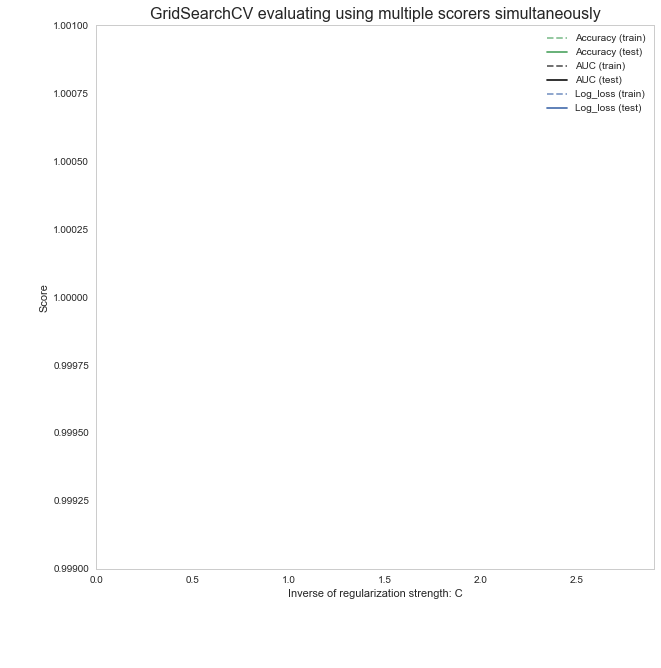

In [108]:
param_grid = {'C': np.arange(1.0, 3, 0.1)}
scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}

gs = GridSearchCV(LogisticRegression(), return_train_score=True,
                  param_grid=param_grid, scoring=scoring, cv=10, refit='Accuracy')

gs.fit(X_train[features], y_train)
results = gs.cv_results_

print('='*20)
print("best params: " + str(gs.best_estimator_))
print("best params: " + str(gs.best_params_))
print('best score:', gs.best_score_)
print('='*20)

plt.figure(figsize=(10, 10))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously",fontsize=16)

plt.xlabel("Inverse of regularization strength: C")
plt.ylabel("Score")
plt.grid()

ax = plt.axes()
ax.set_xlim(0, param_grid['C'].max()) 
#ax.set_ylim(0.35, 0.95)
ax.set_ylim(1, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_C'].data, dtype=float)

for scorer, color in zip(list(scoring.keys()), ['g', 'k', 'b']): 
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = -results['mean_%s_%s' % (sample, scorer)] if scoring[scorer]=='neg_log_loss' else results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = -results['mean_test_%s' % scorer][best_index] if scoring[scorer]=='neg_log_loss' else results['mean_test_%s' % scorer][best_index]
        
    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid('off')
plt.show()

In [105]:
model_train = smf.Logit(y_train, X_train[features])
result_train = model_train.fit()
print(result_train.summary())

Optimization terminated successfully.
         Current function value: 0.022244
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:         write_off_flag   No. Observations:                35212
Model:                          Logit   Df Residuals:                    35204
Method:                           MLE   Df Model:                            7
Date:                Tue, 22 May 2018   Pseudo R-squ.:                  0.8349
Time:                        12:02:07   Log-Likelihood:                -783.24
converged:                       True   LL-Null:                       -4743.3
                                        LLR p-value:                     0.000
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
missed_sub_partial                    0.0860      0.046      

In [106]:
model_test = smf.Logit(y_test, X_test[features])
result_test = model_test.fit()
print(result_test.summary())

Optimization terminated successfully.
         Current function value: 0.019152
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:         write_off_flag   No. Observations:                11738
Model:                          Logit   Df Residuals:                    11730
Method:                           MLE   Df Model:                            7
Date:                Tue, 22 May 2018   Pseudo R-squ.:                  0.8435
Time:                        12:02:33   Log-Likelihood:                -224.81
converged:                       True   LL-Null:                       -1436.0
                                        LLR p-value:                     0.000
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
missed_sub_partial                    0.0205      0.063      

#### The p-values for most of the variables are smaller than 0.05, therefore, most of them are significant to the model.

In [90]:
clf = LogisticRegression() # param for unbalanced data

In [113]:
clf.fit(X_train[features], y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [118]:
y_pred = clf.predict(X_test[features])
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(clf.score(X_test[features], y_test)))

Accuracy of logistic regression classifier on test set: 0.99


In [120]:
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
kfold = model_selection.KFold(n_splits=10, random_state=7)
modelCV = LogisticRegression()
scoring = 'accuracy'
results = model_selection.cross_val_score(modelCV, X_train[features], y_train, cv=kfold, scoring=scoring)
print("10-fold cross validation average accuracy: %.3f" % (results.mean()))

10-fold cross validation average accuracy: 0.994


In [121]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[11396    31]
 [   31   280]]


In [95]:
predictions = clf.predict(X_test[features])
print(classification_report(y_test, predictions))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     11427
          1       0.90      0.90      0.90       311

avg / total       0.99      0.99      0.99     11738



In [ ]:
plt.plot(np.sort(X_train.balance), np.sort(y[:, 1]))
plt.plot(credit.balance, colors.Yes, 'o')
plt.plot(1500, clf.predict_proba(1500)[:, 1], 'o', markersize = 12)
clf.predict_proba(1500)[:, 1]

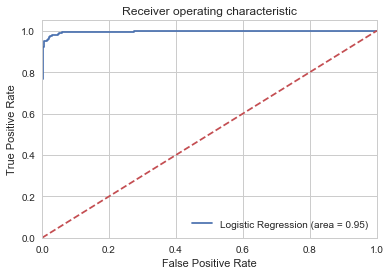

In [123]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, clf.predict(X_test[features]))
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test[features])[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [127]:
y_pred = clf.predict(X_test[features])
print(clf.score(X_test[features], y_test))

0.9947180098824331


In [129]:
print("Accuracy score for Logistic Regression model:\n{:.2f}".format(accuracy_score(y_test, y_pred)))
print("Recall score for Logistic Regression model: \n", recall_score(y_test, y_pred))

Accuracy score for Logistic Regression model:
0.99
Recall score for Logistic Regression model: 
 0.9003215434083601


In [131]:
y_pred = clf.predict(X_train[features])
print(clf.score(X_train[features], y_train))

0.9939793252300352


In [132]:
print("Accuracy score for Logistic Regression model:\n{:.2f}".format(accuracy_score(y_train, y_pred)))
print("Recall score for Logistic Regression model: \n", recall_score(y_train, y_pred))

Accuracy score for Logistic Regression model:
0.99
Recall score for Logistic Regression model: 
 0.9005681818181818
